In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
import scipy.cluster.hierarchy as sch
from sklearn.metrics.pairwise import cosine_distances
import torchaudio
import torch
from tqdm import tqdm
from torch.utils.data import ConcatDataset, DataLoader, Subset

In [2]:
from transformers import AutoProcessor, AutoModelForCTC
from transformers import WavLMModel, Wav2Vec2FeatureExtractor, AutoFeatureExtractor

processor = AutoProcessor.from_pretrained("speech31/XLS-R-english-phoneme")
model = AutoModelForCTC.from_pretrained("speech31/XLS-R-english-phoneme")

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at speech31/XLS-R-english-phoneme were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the che

In [35]:
import os
import pandas as pd


def prepare_dataset(feature_extractor, root_path):

    data = pd.read_csv(os.path.join(root_path, "phoneme_frames.csv"))
    data["filename"] = data["filename"].apply(
        lambda x: os.path.basename(x).split(".")[0]
    )
    data = data.sort_values(by=["filename"])
    filenames_list = set(data["filename"])

    def return_collate_fn(batch):
        res = {}
        model_input_name = feature_extractor.model_input_names[0]

        res["filenames"] = [
            "%d-%d-%04d" % (item[3], item[4], item[5]) for item in batch
        ]
        res["phonemes"] = [
            eval(data[data["filename"] == filename]["phoneme_frames"].iloc[0])
            for filename in res["filenames"]
            if filename in filenames_list
        ]

        waveform = [item[0][0].numpy()                 
                    for i, item in enumerate(batch)
                    if res["filenames"][i] in filenames_list]
        inputs = feature_extractor(
            waveform,
            sampling_rate=16000,
            return_attention_mask=True,
            padding=True,
            return_tensors="pt",
        )
        # print(inputs.get(model_input_name).shape)

        res["org_waveform"] = torch.nn.utils.rnn.pad_sequence(
            [
                item[0][0]
                for i, item in enumerate(batch)
                if res["filenames"][i] in filenames_list
            ],
            batch_first=True,
        )

        res[model_input_name] = inputs.get(model_input_name)
        res["attention_mask"] = inputs.get("attention_mask")
        return res

    return return_collate_fn

In [83]:
def load_librispeech_dataset(
    root_path: str,
    split="train",
    batch_size: int = 32,
    num_workers: int = 2,
    percentage=0.1,
    collate_fn=None,
) -> DataLoader:
    """Load the LibriSpeech dataset and return a DataLoader.

    This function initializes the LibriSpeech dataset and creates a DataLoader
    with a custom collate function to handle variable-length audio samples.

    Args:
        root_path (str): The path to the directory where the dataset will be stored.
        split (str): train or val .
        batch_size (int, optional): The number of samples per batch. Defaults to 32.
        num_workers (int, optional): The number of subprocesses to use for data loading.
            Defaults to 2.
        percentage (float, optional): The percentage that used to generate features

    Returns:
        DataLoader: A DataLoader object that provides batches of audio waveforms
        and their corresponding metadata from the LibriSpeech dataset.

    Raises:
        FileNotFoundError: If the dataset cannot be downloaded or accessed.
    """

    if split == "train":
        # Load individual datasets
        train_clean_100 = torchaudio.datasets.LIBRISPEECH(
            root=root_path, url="train-clean-100", download=True
        )
        train_clean_360 = torchaudio.datasets.LIBRISPEECH(
            root=root_path, url="train-clean-360", download=True
        )
        train_other_500 = torchaudio.datasets.LIBRISPEECH(
            root=root_path, url="train-other-500", download=True
        )
        # Combine the datasets
        dataset = ConcatDataset([train_clean_100, train_clean_360, train_other_500])
    else:
        dev_clean = torchaudio.datasets.LIBRISPEECH(
            root=root_path, url="dev-clean", download=True
        )
        dev_other = torchaudio.datasets.LIBRISPEECH(
            root=root_path, url="dev-other", download=True
        )
        dataset = ConcatDataset([dev_clean, dev_other])

    # Randomly select 10% of the dataset,  and then create a Subset using the selected indices
    subset_size = int(len(dataset) * percentage)
    indices = torch.randperm(len(dataset))[:subset_size]
    dataset = Subset(dataset, indices)

    # Create a DataLoader with the custom collate function
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
    )

    return dataloader


dataset_root_path = "/home/ay/data2/datasets/Lib"
dataloader = load_librispeech_dataset(
    dataset_root_path,
    split="train",
    percentage=0.5,
    num_workers=4,
    collate_fn=prepare_dataset(
        processor.feature_extractor, root_path=dataset_root_path
    ),
    batch_size=1
)
ds = dataloader.dataset

In [ ]:
dl = iter(dataloader)
next(dl)

# Encoder

In [73]:
import torch
import os
import torch.nn as nn
import torchaudio
import sys
sys.path.append("/home/ay/Coding2/0-Deepfake/2-Audio/models/OurModels/textless")
from textless.data.speech_encoder import SpeechEncoder
from matplotlib import pyplot as plt

In [89]:
class MySpeechEncoder(nn.Module):
    def __init__(self, dense_model_name="hubert-base-ls960", quantizer_name="kmeans", vocab_size=500):
        super().__init__()
        self.model = self.load_SpeechEncoder(dense_model_name, quantizer_name=quantizer_name, vocab_size=vocab_size)

    def load_SpeechEncoder(self, dense_model_name, quantizer_name="kmeans", vocab_size=500):
        # We can build a speech encoder module using names of pre-trained
        # dense and quantizer models.  The call below will download
        # appropriate checkpoints as needed behind the scenes. We can
        # also construct an encoder by directly passing model instances
        encoder = SpeechEncoder.by_name(
            dense_model_name=dense_model_name,
            quantizer_model_name=quantizer_name,
            vocab_size=vocab_size,
            deduplicate=True,
            need_f0=False,
        )
        return encoder

    def encode_speech(self, x, **kwargs):
        # res is a dict with keys ('dense', 'units', 'durations').
        # It can also contain 'f0' if SpeechEncoder was initialized
        # with need_f0=True flag.
        """

        Return:
            a dict with {
                "units" : a unit id list, with no repetition
                "dense" : a tensor with shape (T, 768)
                "durations" : the duration for each unit in the `units`
                "original_units": a unit id list with length `T`
            }
        """
        res = self.model(x)

        units = res["units"]  # tensor([71, 12, 57, ...], ...)
        res["original_units"] = torch.repeat_interleave(units, res["durations"])[None, ...]
        return res

In [90]:
speech_encoder = MySpeechEncoder(vocab_size=200)
encoder = speech_encoder.cuda(0)


2024-12-04 16:08:34 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/ay/Coding2/0-Deepfake/2-Audio/experiments/speech_tokenization
2024-12-04 16:08:34 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': '/checkpoint/wnhsu/data/librispeech/960h/iter/250K_50hz_km100_mp0_65_v2', 'fine_tuning': False, 'labels': ['layer6.km500'], 'label_dir': None, 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-12-04 16:08:34 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout':

## Custome Encoder

In [38]:
from kmeans_model import CustomSpeechEncoder

encoder = CustomSpeechEncoder(vocab_size=150)
# units = encoder.encode_speech(x['org_waveform'], attention_mask=x['attention_mask'])['original_units']
# b = encoder.encode_speech(x['org_waveform'])['original_units']

/home/ay/anaconda3/envs/torch/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at microsoft/wavlm-base were not used when initializing WavLMModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing WavLMModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMModel were not initialized from the 

In [39]:
model = model.cuda(0)
encoder = encoder.cuda(0)

# Plot

In [101]:
phoneme_list = []
unit_list = []
num = 0
for x in tqdm(dataloader):
    with torch.no_grad():
        # batch_res = model(x["input_values"].cuda(0), attention_mask=x["attention_mask"].cuda(0), output_hidden_states=True)
        # logits = batch_res.logits
        # phoneme_ids = torch.argmax(logits, dim=-1)
        phoneme_ids = x["phonemes"]
        units = encoder.encode_speech(
            x["org_waveform"].cuda(0), attention_mask=x["attention_mask"].cuda(0)
        )["original_units"].cpu().numpy()
        for j in range(len(phoneme_ids)):
            # length = x['attention_mask'][j].sum()
            length = min(len(phoneme_ids[j]), x['attention_mask'][j].sum())
            length = min(length, len(units[j]))
            phoneme_list += phoneme_ids[j][:length]
            unit_list += list(units[j][:length])
            # print(len(phoneme_list), len(unit_list))
    num += 1
    if num > 100:
        break

  0%|          | 100/140620 [00:04<1:42:18, 22.89it/s]


In [102]:
units.shape, len(phoneme_ids)

((1, 745), 1)

In [93]:
len(phoneme_list), len(unit_list)

(60266, 60266)

In [103]:
import pandas as pd

# Create a DataFrame to store phoneme-unit pairs
data = pd.DataFrame({"phoneme_id": phoneme_list, "unit_id": unit_list})

# Step 1: Calculate joint counts for each (phoneme, unit) pair
joint_counts = data.groupby(["phoneme_id", "unit_id"]).size().reset_index(name="count")

# Step 2: Calculate marginal counts for units
unit_marginals = data.groupby("unit_id").size().reset_index(name="unit_count")

# Step 3: Merge the joint and marginal counts
joint_counts = pd.merge(joint_counts, unit_marginals, on="unit_id")

# Step 4: Calculate the conditional probability P(phoneme | unit)
joint_counts["P_phoneme_given_unit"] = (
    joint_counts["count"] / joint_counts["unit_count"]
)

# Step 5: Display the results
print(joint_counts[["phoneme_id", "unit_id", "P_phoneme_given_unit"]])

     phoneme_id  unit_id  P_phoneme_given_unit
0           AA0       16              0.006211
1           AA1       16              0.127329
2           AA2       16              0.006211
3           AE1       16              0.012422
4           AH0       16              0.018634
...         ...      ...                   ...
3107         sp      138              0.960739
3108        sil      167              0.020080
3109         sp      167              0.979920
3110         sp      107              1.000000
3111         sp      166              1.000000

[3112 rows x 3 columns]


In [97]:
joint_counts

,phoneme_id,unit_id,count,unit_count,P_phoneme_given_unit
0,AA0,"tensor(0, dtype=torch.int32)",1,1,1.0
1,AA0,"tensor(26, dtype=torch.int32)",1,1,1.0
2,AA0,"tensor(26, dtype=torch.int32)",1,1,1.0
3,AA0,"tensor(52, dtype=torch.int32)",1,1,1.0
4,AA0,"tensor(52, dtype=torch.int32)",1,1,1.0
...,...,...,...,...,...
60756,spn,"tensor(194, dtype=torch.int32)",1,1,1.0
60757,spn,"tensor(196, dtype=torch.int32)",1,1,1.0
60758,spn,"tensor(196, dtype=torch.int32)",1,1,1.0
60759,spn,"tensor(196, dtype=torch.int32)",1,1,1.0


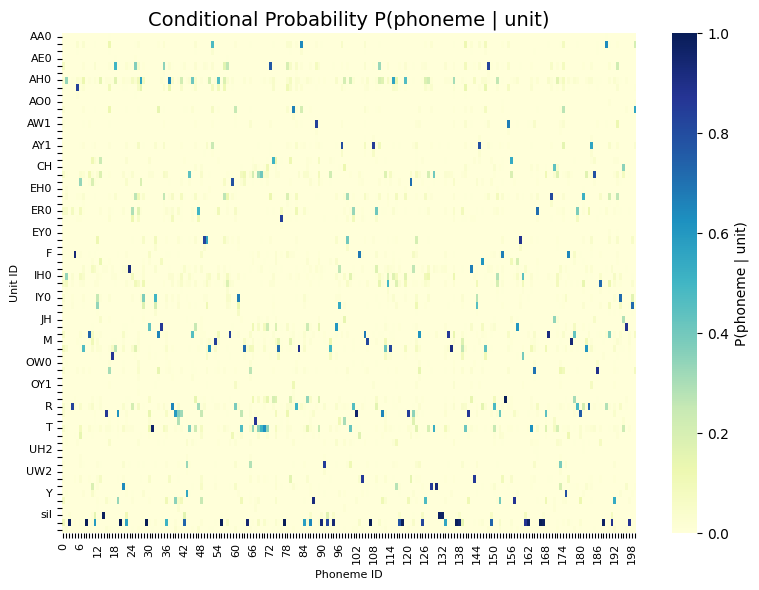

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Step 1: Pivot the joint_counts DataFrame to create a matrix
# We want units as rows and phonemes as columns
probability_matrix = joint_counts.pivot(
    index="phoneme_id", columns="unit_id", values="P_phoneme_given_unit"
)
probability_matrix = probability_matrix.fillna(0)
# Step 2: Plot the matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    probability_matrix,
    annot=False,
    cmap="YlGnBu",
    fmt=".2f",
    cbar_kws={"label": "P(phoneme | unit)"},
)


# Set the number of ticks you want on each axis
# ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='none'))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='none'))

# Optionally, set the tick labels to display all values
ax.set_xticks(np.arange(probability_matrix.shape[1]) + 0.5)
ax.set_yticks(np.arange(probability_matrix.shape[0]) + 0.5)


# Step 3: Set labels and title
plt.title("Conditional Probability P(phoneme | unit)", fontsize=14)
plt.xlabel("Phoneme ID", fontsize=8)
plt.ylabel("Unit ID", fontsize=8)
# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=8)  # Rotate labels by 90 degrees and set font size
plt.yticks(rotation=0, fontsize=8)   # Keep y-axis labels horizontal and set font size

# Step 4: Show the plot
plt.tight_layout()
plt.show()

In [105]:
probability_matrix

unit_id,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
phoneme_id,,,,,,,,,,,,,,,,,,,,,
AA0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
AA1,0.002786,0.00000,0.000000,0.000000,0.00000,0.036827,0.00000,0.038339,0.000000,0.000000,...,0.005025,0.00000,0.000000,0.009494,0.0,0.000000,0.000000,0.000000,0.0,0.206897
AA2,0.000000,0.00000,0.000000,0.000000,0.00000,0.005666,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
AE0,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
AE1,0.072423,0.00000,0.000000,0.003067,0.00000,0.002833,0.00000,0.019169,0.000000,0.000000,...,0.025126,0.00000,0.000000,0.221519,0.0,0.000000,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z,0.072423,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.003559,...,0.000000,0.00000,0.536697,0.000000,0.0,0.000000,0.000000,0.014414,0.0,0.000000
ZH,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
sil,0.000000,0.00000,0.016892,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.07513,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# Assuming 'joint_counts' DataFrame is already defined and 'probability_matrix' is computed

# Fill NaN values with zero
probability_matrix = probability_matrix.fillna(0)

### Method 1: Sorting Based on Most Probable Associations

# Step 1: Identify the most probable phoneme for each unit
max_phoneme_per_unit = probability_matrix.idxmax(axis=1)

# Step 2: Create a mapping and sort units
unit_phoneme_mapping = pd.DataFrame({
    'unit_id': probability_matrix.index,
    'phoneme_id': max_phoneme_per_unit.values
})
unit_phoneme_mapping_sorted = unit_phoneme_mapping.sort_values('phoneme_id')
sorted_units = unit_phoneme_mapping_sorted['unit_id']
sorted_phonemes = probability_matrix.columns  # Keep all phonemes

# Step 3: Reorder the probability matrix
probability_matrix_sorted = probability_matrix.loc[sorted_units, sorted_phonemes]

# Step 4: Plot the sorted heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    probability_matrix_sorted,
    annot=False,
    cmap="YlGnBu",
    cbar_kws={"label": "P(phoneme | unit)"},
)
plt.title("P(phoneme | unit) - Sorted by Most Probable Associations", fontsize=14)
plt.xlabel("Phoneme ID", fontsize=12)
plt.ylabel("Unit ID", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()